# Modern Neural Networks

In this tutorial, we'll cover "modern" neural networks.  In this case that specifically means deep, residual, convolutional neural networks.  Notably, the field of machine learning is "moving on" a bit these days from convoltutional neural networks.  The latest models are what are called "transformers" - we won't cover them today or likely at all in this course, but they certainly claim to be the next Big Thing.

## Today's tutorial Agenda

We'll cover 3 things in the tutorial-focused portion of today's session:

1) ImageNet Dataset, from a high view.  (More next week!)

2) Recap of Convolutions, and the vanishing gradient problem

3) Residual Layers and the ResNet development.

## 1) ImageNet from a Mile High

In the 2010s, there was one dataset to rule them all: [ImageNet](https://www.image-net.org/).  We will use this dataset for the rest of this series since it's the territory of "Big Data."  The dataset is just about 200GB on disk, and contains 1.4M images to classify spread over 1000 classes.  Modern datasets from science are actually growing even bigger!  For today, we will use the data loading as a *black box*, paying no heed to how we're loading the data or what it's doing.  We will circle back next week, however, to get into this.

In [1]:
import tensorflow as tf
import json

In [2]:
# What's in this function?  Tune in next week ...
from ilsvrc_dataset import get_datasets

--------------------------------------------------------------------------

  Local host:   thetagpu06
  Local device: mlx5_0
--------------------------------------------------------------------------


[1668537171.022039] [thetagpu06:2825905:0]    ucp_context.c:1079 UCX  ERROR exceeded transports/devices limit (74 requested, up to 64 are supported)


In [3]:
class FakeHvd:
    
    def size(self): return 1
    
    def rank(self): return 0


with open("ilsvrc.json", 'r') as f: 
    config = json.load(f)

print(json.dumps(config, indent=4))
    
    
config['hvd'] = FakeHvd()



{
    "data": {
        "handler": "ilsvrc_dataset",
        "batch_size": 128,
        "train_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt",
        "test_filelist": "/lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt",
        "shuffle_buffer": 200000,
        "reshuffle_each_iteration": true,
        "num_parallel_readers": 32,
        "prefetch_buffer_size": 10,
        "crop_image_size": [
            256,
            256
        ],
        "num_classes": 1000,
        "num_channels": 3
    }
}


In [4]:
train_ds, val_ds = get_datasets(config)

num labels: 1000
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_train_filelist.txt
input filelist contains 1281167 files, estimated batches per rank 10009
build dataset /lus/grand/projects/ALCFAITP/ilsvrc_val_filelist.txt
input filelist contains 50000 files, estimated batches per rank 390


In [5]:
images, labels = next(iter(train_ds.take(1)))

In [6]:
print(images.shape)
print(labels.shape)

(128, 256, 256, 3)
(128,)


In [7]:
first_image = images[0]

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


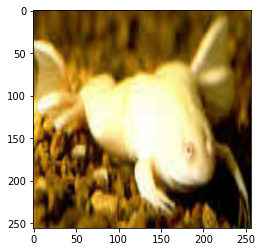

In [9]:
# Divide by 255 to put this in the range of 0-1 for floating point colors
plt.imshow(first_image/255.) 

## What is a convolution doing, again?

Convolution kernels are operating on entire images in small patches.  

![Convolution Kernel](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_02_17A-ConvolutionalNeuralNetworks-WHITEBG.png)


That's a **single** convolution.  Convolutional Layers are learning multiple filters:

![Convolution Layer](https://miro.medium.com/max/1400/1*u2el-HrqRPVk7x0xlvs_CA.png)

In [10]:
# Using 3 output filters here to simulate RGB.  
# You can - and SHOULD - use more for bigger networks
sample_conv_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=1)

In [11]:
# Apply this layer to all images:
modified_output = sample_conv_layer(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


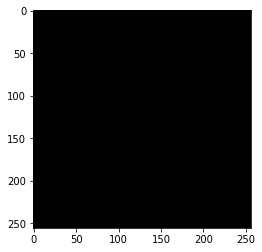

In [12]:
first_image = modified_output[0]
# Divide by 255 to put this in the range of 0-1 for floating point colors
plt.imshow(first_image/255.) 

This image is just as crisp as the original, but has had it's colors totally shifted.  That's expected: the convolution kernel size was just 1x1, or one pixel at a time.  So it's taking, for every pixel, the RGB value times a kernel (in this case, a vector):

$$ output = R*k_1 + G*k_2 + B*k_3$$


More generally, this becomes a sum over neighboring pixels (for kernel sizes > 1).

We also produced 3 output "filters" - here, RGB again, but it can be more!  Each output filter for a convolution layer will create a $k x k$ kernel for every input filter, that are all summed together.  The total number of parameters is then:

$$ n_{params} = N_{Input Filters} \times N_{Output Filters} \times k_{x} \times k_{y} $$

In [13]:
sample_conv_layer_7x7 = tf.keras.layers.Conv2D(filters=3, kernel_size=7)
modified_output_7x7 = sample_conv_layer_7x7(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


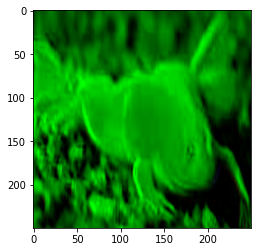

In [14]:
first_image = modified_output_7x7[0]
# Divide by 255 to put this in the range of 0-1 for floating point colors
plt.imshow(first_image/255.) 

This time the output is much blurrier - because this kernel has a 7x7 pixel size instead of a 1x1 pixel size.

### Strides, Padding, Output Size

To apply a convolution, one algorithm takes the first output pixel to be the one where the filter just fits into the top left corner of the input image, and scans over (and then down) one pixel at a time.  There is nothing special about that though!  Kernels can skip pixels to reduce the output image size (sometimes called an downsampling convolution) and they can start with incomplete corners of the input images (padding with 0) to preserve the same output size.

- **Padding** represents the operation of handling the corner and edge cases so the output image is the same size as the input image.  Often you will see "valid" (apply the kernel only in valid locations) or "same" (add padding to make sure the output is the same size).

- **Stride** represents how many pixels are skipped between applications of the convolution.

- **Bottleneck** Layers are special convolution layers that have kernel size = 1, stride = 1 that preserve the output size and only look at single pixels at at time - though they look at all filters on a pixel.  A bottleneck layer is mathematically the same as applying the same MLP to each individual pixel's filters.

## The case for ResNet: Vanishing Gradients

One of the motivations for the network we'll develop in the second half is the so-called "vanishing gradient problem":  The gradient of each layer depends on the gradient of each layer after it (remember the gradients flow backwards through the network).  Deeper and deeper networks that stack convolutions end up with smaller and smaller gradients in early layers.

In [27]:
class DenseLayer(tf.keras.Model):
    
    def __init__(self, n_filters):
        tf.keras.Model.__init__(self)
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )
        
    def __call__(self, inputs):
        
        x = inputs
        
        output1 = self.conv1(inputs)
        
        output1 = tf.keras.activations.sigmoid(output1)
        
        return output1
    
class ResidualLayer(tf.keras.Model):
    
    def __init__(self, n_filters):
        tf.keras.Model.__init__(self)
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )
        
        self.conv2 = tf.keras.layers.Conv2D(
            filters     = n_filters,
            kernel_size = (3,3),
            padding     = "same"
        )
    
    def __call__(self, inputs):
        
        x = inputs
        
        output1 = self.conv1(inputs)
        
        output1 = tf.keras.activations.sigmoid(output1)
        
        output2 = self.conv2(output1)

        return tf.keras.activations.sigmoid(output2 + x)
        

In [28]:
regular_layers  = [ DenseLayer(3) for i in range(100)]
residual_layers = [ ResidualLayer(3) for i in range(50)] # 2 convolutions per layer, so do half!

Apply these layers to the input data, and then compute a loss value (even it it's totally artificial!)

In [29]:
with tf.GradientTape() as tape:
    output = images
    for layer in regular_layers:
        output = layer(output)
    regular_loss = tf.reduce_mean(output)

Compute the gradients per layer:

In [30]:
regular_params = [l.trainable_weights for l in regular_layers]
gradients = tape.gradient(regular_loss, regular_params)

Lets do the same with the residual layers:

In [31]:
with tf.GradientTape() as tape:
    output = images
    for layer in residual_layers:
        output = layer(output)
    residual_loss = tf.reduce_mean(output)

In [32]:
residual_params = [l.trainable_weights for l in residual_layers]
residual_gradients = tape.gradient(residual_loss, residual_params)

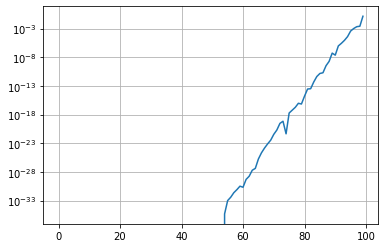

In [38]:
# Compute the ratio of the gradient to the weights for each layer:
regular_mean_ratio = []
for layer, grad in zip(regular_params, gradients):
    regular_mean_ratio.append(tf.abs(tf.reduce_max(grad[0]) / tf.reduce_max(layer[0])))
    
plt.plot(range(len(regular_mean_ratio)), regular_mean_ratio)
plt.grid()
plt.yscale("log")

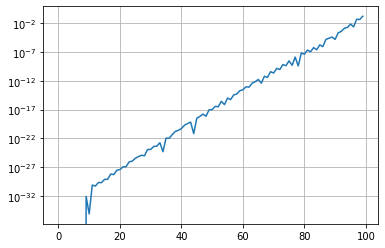

In [39]:
# Compute the ratio of the gradient to the weights for each layer:
residual_mean_ratio = []
for layer, grad in zip(residual_params, residual_gradients):

    residual_mean_ratio.append(tf.abs(tf.reduce_max(grad[0]) / tf.reduce_max(layer[0])))
    residual_mean_ratio.append(tf.abs(tf.reduce_max(grad[2]) / tf.reduce_max(layer[2])))

plt.plot(range(len(residual_mean_ratio)), residual_mean_ratio)
plt.yscale("log")
plt.grid()

The difference in the magnitude of the gradients is striking.  Yes, there are ways to keep the magnitude of the gradients more reasonable through normalization layers (and that helps in residual networks too!), but most cases that use residual connections show significant benefits compared to regular convolutional neural networks, especially as the networks get deeper.